In [1]:
#|default_exp n3b5_phate_embedding_of_sphere

import numpy as np
import matplotlib.pyplot as plt

# datasets
from diffusion_curvature.datasets import sphere, torus
from autometric.n0d2_datasets import make_swiss_roll, generate_sine_wave_dataset
from autometric.n0u1_visualization import plot_jacobian
from autometric.n0u2_jacobian import compute_jacobian_function

import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"

# models
import torch
from autometric.autoencoders import DerrickTheAutoencoder
from diffusion_curvature.utils import plot_3d


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
import plotly.express as px

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_4055470/1794899662.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-poster') #sets the size of the charts


# Approximating a PHATE embedding of the Sphere

In [2]:
# Xs, thetas = make_swiss_roll(turns=2, a=0.1, base_delta_theta=0.1 * 2 * np.pi, theta=1.5 * np.pi, noise=0.)
# Xs = generate_sine_wave_dataset(num_points=2000, amplitude=2, frequencies=(1, 1))
Xs, N = sphere(n=2000, noise=0.05)
# ambient_noise = np.random.normal(0, 0.05, size=Xs.shape)
# Xs += ambient_noise

fig = px.scatter_3d(x=Xs[:, 0], y=Xs[:, 1], z=Xs[:, 2])
fig.show()
X = Xs

Computing PHATE with phate_decay=40 and n_neighbors=15
Calculating PHATE...
  Running PHATE on 2000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.08 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 7.05 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.60 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.58 seconds.
Calculated PHATE in 16.39 seconds.


/tmp/ipykernel_4055470/2736215969.py:11: DeprecationWarning:

Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.



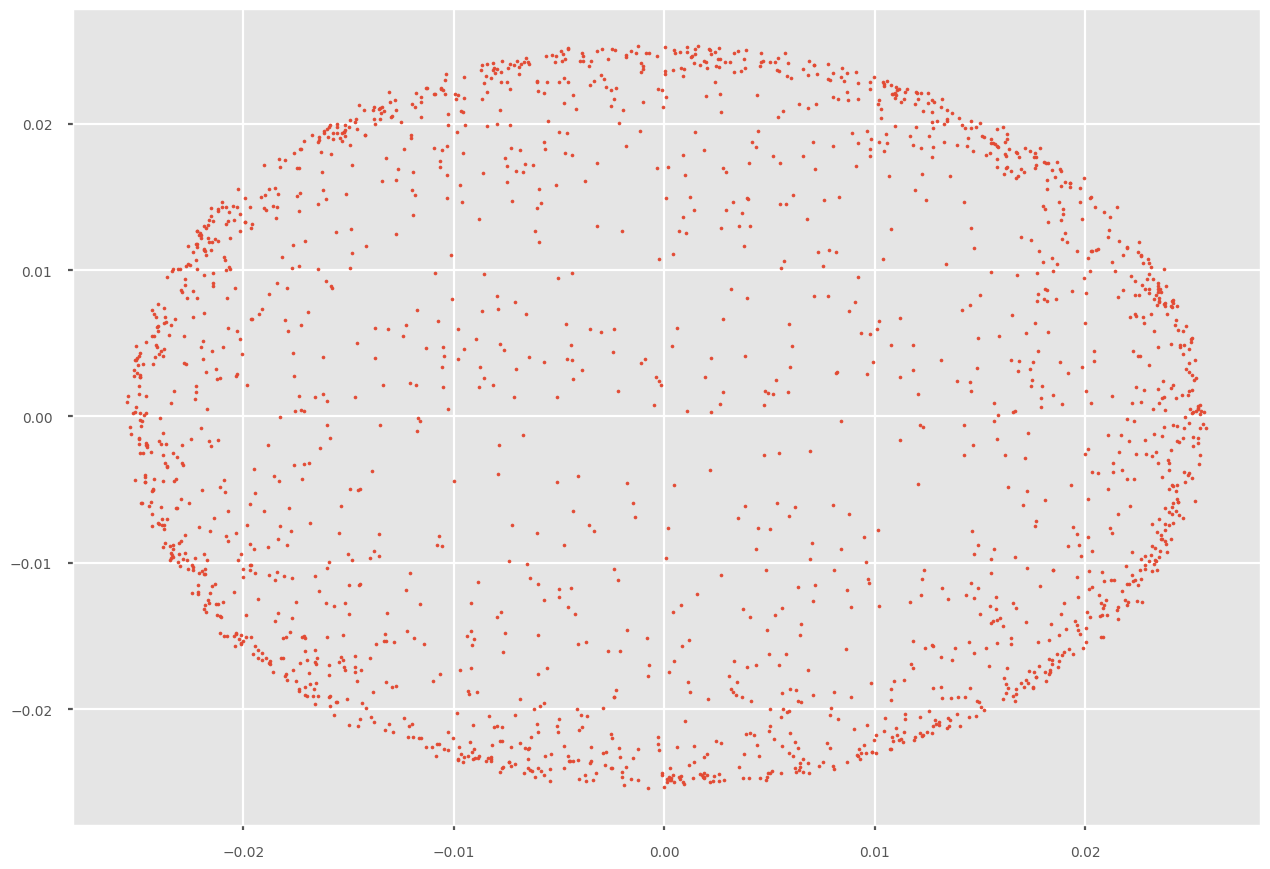

In [3]:
import phate
# PHATE's parameters
phate_decay = 40
n_neighbors = 15
phate_gamma = 1
phate_knn = 15

print(f"Computing PHATE with {phate_decay=} and {n_neighbors=}")
phate_op = phate.PHATE(gamma=phate_gamma, knn=phate_knn, random_state=42) #n_components = 2, decay=phate_decay, knn=self.n_neighbors
phate_coords = phate_op.fit_transform(X)
phate.plot.scatter2d(phate_coords)
phate_coords = torch.tensor(phate_coords)
phate_D = torch.cdist(phate_coords, phate_coords).detach()


In [4]:
from autometric.autoencoders import DistanceMatchingAutoencoder
from autometric.datasets import train_and_testloader_from_pointcloud_with_distances
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

model_filename = "phate_sphere_encoder.pt"

# Create dataloaders
trainloader, testloader = train_and_testloader_from_pointcloud_with_distances(
    X, # <---- Pointcloud
    phate_D, # <---- Distance matrix to match
    batch_size=64)
train_sample = next(iter(trainloader))

# Initialize model and trainer
model = DistanceMatchingAutoencoder(
    input_dim = train_sample['x'].shape[1],
    intrinsic_dim = 2,
    reconstruction_weight = 1,
    distance_weight = 1,
    )
early_stopping = EarlyStopping('val_loss', patience=500)
trainer = Trainer(
    max_epochs=50, 
    accelerator='cuda',
    callbacks=[early_stopping],
    use_distributed_sampler=False,
    log_every_n_steps=50,
    )

if os.path.exists(f'../data/{model_filename}'):
    model.load_state_dict(torch.load(f'../data/{model_filename}'))
else:
    trainer.fit(
        model=model,
        train_dataloaders=trainloader,
        val_dataloaders=testloader,
    )
    torch.save(model.state_dict(), f'../data/{model_filename}')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/autometric/autometric/datasets.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.

INFO: Using pytorch backend
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/torch/_functorch/deprecated.py:88: UserWarning:

We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning:

We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorc

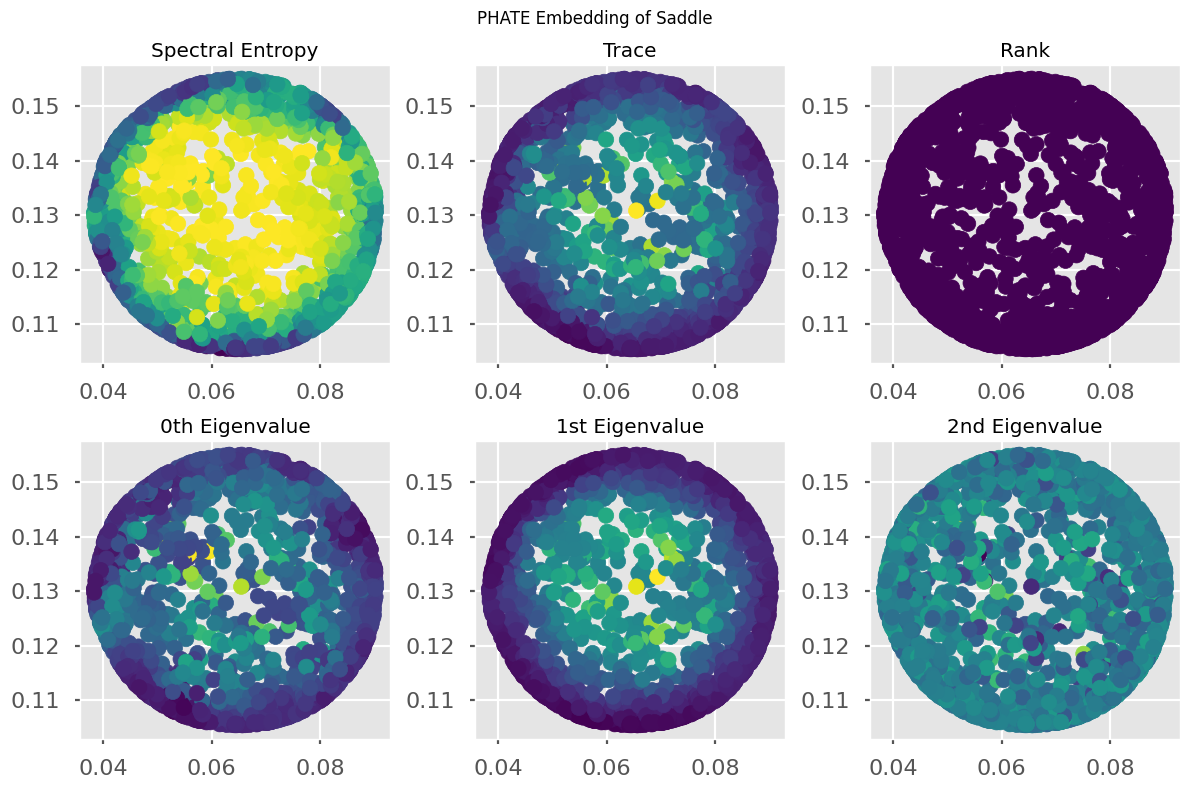

In [5]:
from autometric.geometry import visualize_encoder_pullback_metrics
visualize_encoder_pullback_metrics(model, trainloader, title = "PHATE Embedding of Saddle")

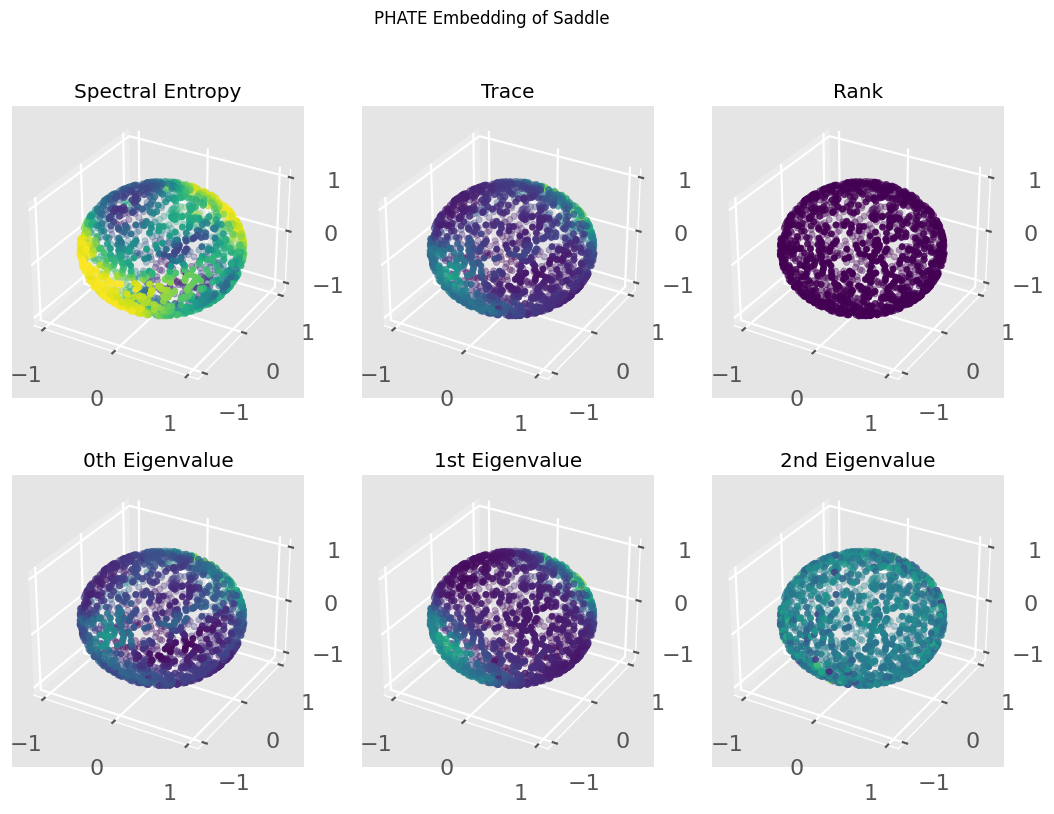

In [6]:
from autometric.geometry import visualize_encoder_pullback_metrics_in_ambient_space
visualize_encoder_pullback_metrics_in_ambient_space(model, trainloader, title = "PHATE Embedding of Saddle")

In [7]:
from autometric.geometry import normal_vectors_of_encoder_pullback
pullback_Ns = normal_vectors_of_encoder_pullback(model, trainloader)

In [8]:
# from autometric.datasets import plot_3d_vector_field
# plot_3d_vector_field(X[:500],N[:500],pullback_Ns[:500], names = ["Normal Vectors", "Encoder Pullback Vectors"], arrow_length=0.1, upload_to_information_superhighway=True, filename="Encoder Pullback Normal Vectors on Saddle")

In [9]:
X_tensor = torch.from_numpy(Xs).float()
jac = compute_jacobian_function(model.encoder, X_tensor)
U, S, V = torch.linalg.svd(jac, full_matrices=False)

In [10]:
X_enc = model.encoder(X_tensor)

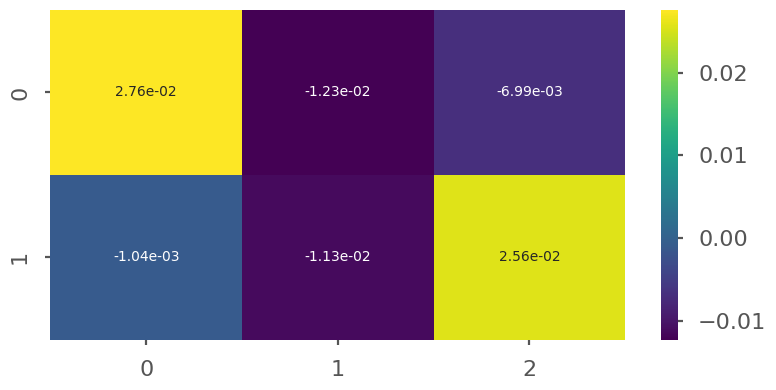

[[ 0.02760177 -0.01229132 -0.00698743]
 [-0.00103686 -0.01126764  0.02560047]]


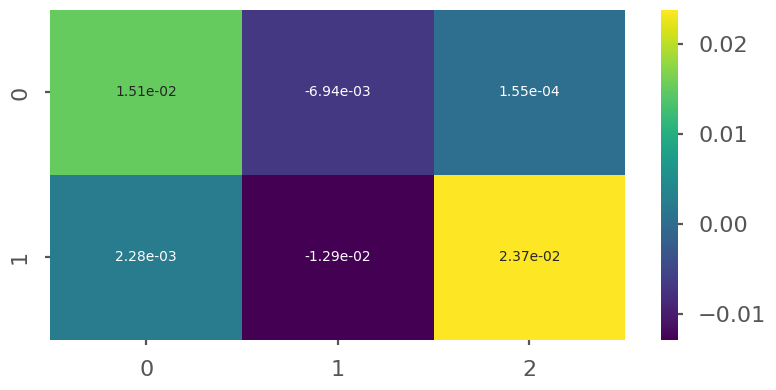

[[ 0.01508555 -0.00694077  0.00015523]
 [ 0.00227837 -0.01288074  0.02374684]]


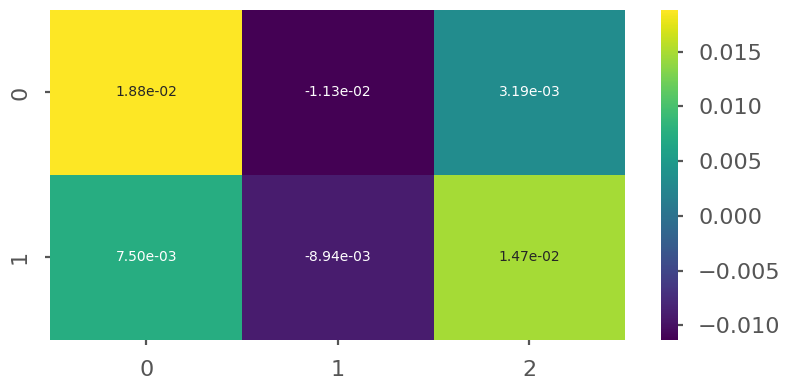

[[ 0.01881064 -0.01128948  0.00319412]
 [ 0.00749701 -0.00894266  0.01474928]]


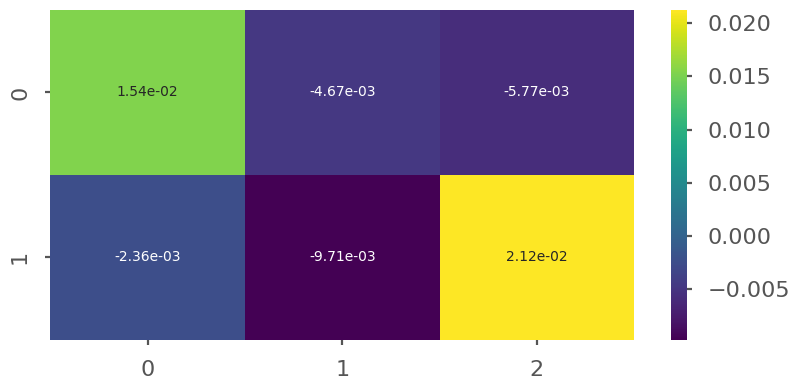

[[ 0.01536505 -0.00466949 -0.00576546]
 [-0.00236278 -0.00971291  0.02122703]]


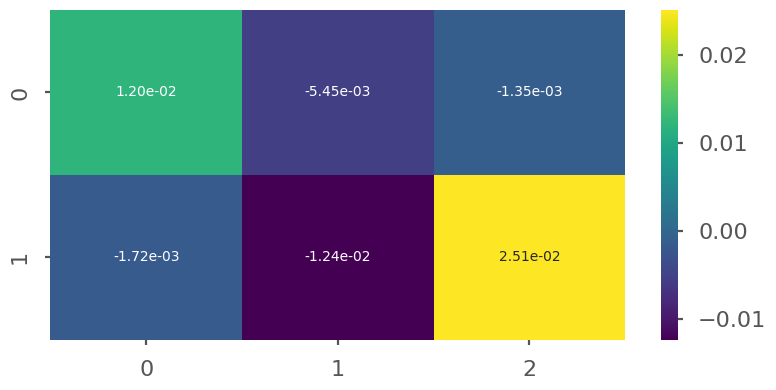

[[ 0.01197812 -0.00544566 -0.00134883]
 [-0.00172147 -0.01240069  0.02514171]]


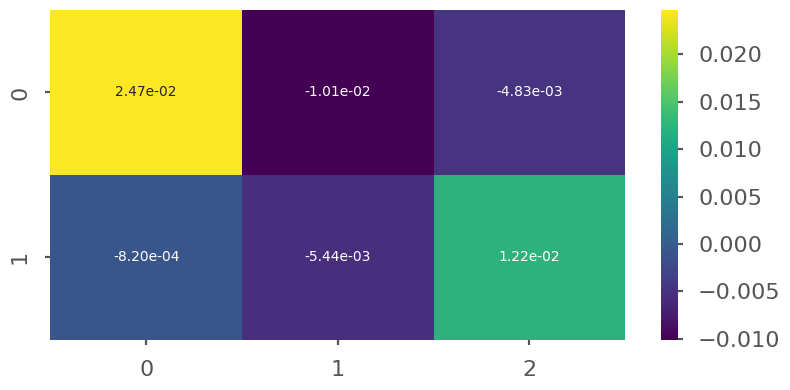

[[ 0.02465783 -0.01007698 -0.00483349]
 [-0.00081982 -0.00543892  0.01220329]]


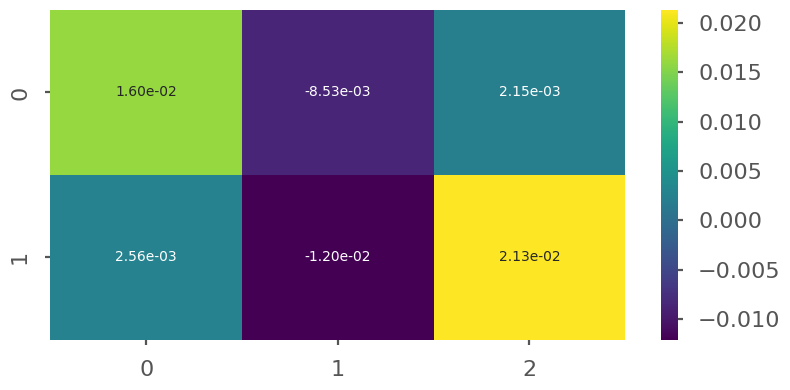

[[ 0.01604648 -0.00852687  0.00214834]
 [ 0.00255994 -0.01203826  0.02127484]]


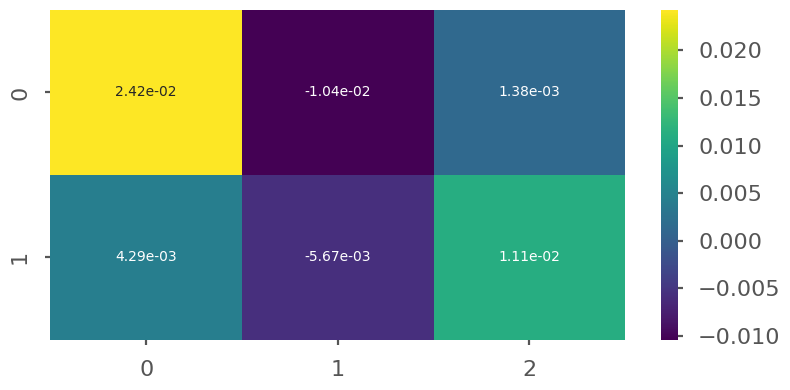

[[ 0.02424734 -0.01037108  0.00138081]
 [ 0.00429392 -0.0056705   0.0111467 ]]


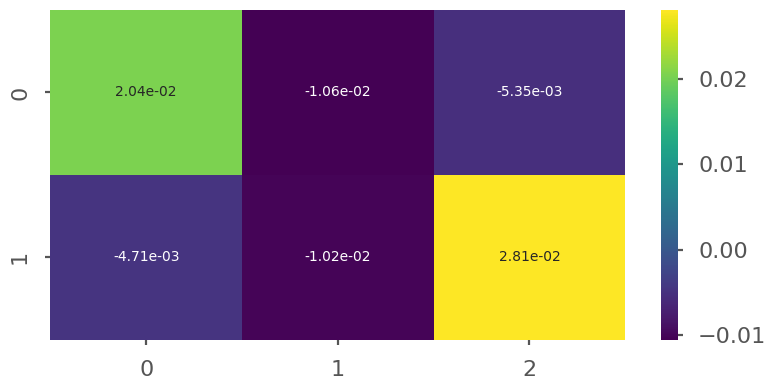

[[ 0.02043956 -0.01056881 -0.0053532 ]
 [-0.00470937 -0.01021056  0.02810427]]


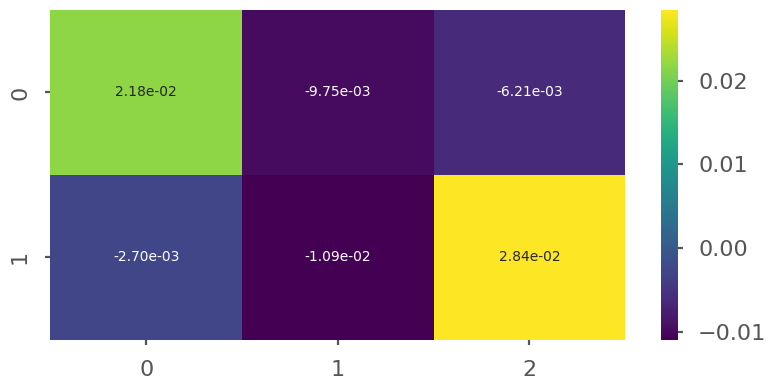

[[ 0.02180528 -0.009748   -0.00620689]
 [-0.00269737 -0.01090876  0.0284355 ]]


In [11]:
for i in range(10):
    j = np.random.choice(X.shape[0])
    plot_jacobian(X_tensor, X_enc, U, V, S, jac, j)